In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 10.2 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 47.2 MB/s 
     |████████████████████████████████| 6.6 MB 31.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 12.1 MB/s 
     |████████████████████████████████| 409 kB 44.3 MB/s 
     |████████████████████████████████| 140 kB 43.6 MB/s 
     |████████████████████████████████| 1.1 MB 9.9 MB/s 
     |████████████████████████████████| 144 kB 48.6 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 48.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc, f1_score
#from pytorch_lightning.metrics.functional import f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

# Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Project/Capstone/data/H_section_onehot.csv",index_col=0) # 파일 업로드
df = data.iloc[:100,:]
df.head()

,patent_number,patent_abstract,H01B,H01C,H01F,H01G,H01H,H01J,H01K,H01L,...,H04S,H04T,H04W,H05B,H05C,H05F,H05G,H05H,H05K,H99Z
0,7640641,Method for producing parts for passive electro...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,7640647,Projecting elongate stub walls are provided on...,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,7640648,Methods of fabricating a magnetic flux channel...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7640652,A method of making a current sensing chip resi...,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,7640653,A producing method of producing a solid state ...,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2) # train,test split
val_df, test_df = train_test_split(val_df, test_size = 0.5)
train_df.shape, val_df.shape, test_df.shape

((80, 54), (10, 54), (10, 54))

# Preprocessing

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[2:] # label 설정
#df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

# Tokenization

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME) # raw text를 token으로(input) 바꾸기 위해 BertTokenizer 사용

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# label example
sample_row = df.iloc[0]
sample_comment = sample_row.patent_abstract
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_comment)
print()
print(sample_labels.to_dict())

Method for producing parts for passive electronic components according to which: a laminated strip (1) is produced which is constituted by at least one stack of a thin metal strip and a layer of adhesive material, and at least one part (6) is cut from the laminated strip (1), the cutting operation being carried out using a method which comprises at least one step for etching by means of sandblasting. Parts produced.

{'H01B': 0, 'H01C': 0, 'H01F': 1, 'H01G': 0, 'H01H': 0, 'H01J': 0, 'H01K': 0, 'H01L': 0, 'H01M': 0, 'H01P': 0, 'H01Q': 0, 'H01R': 0, 'H01S': 0, 'H01T': 0, 'H02B': 0, 'H02G': 0, 'H02H': 0, 'H02J': 0, 'H02K': 0, 'H02M': 0, 'H02N': 0, 'H02P': 0, 'H02S': 0, 'H03B': 0, 'H03C': 0, 'H03D': 0, 'H03F': 0, 'H03G': 0, 'H03H': 0, 'H03J': 0, 'H03K': 0, 'H03L': 0, 'H03M': 0, 'H04B': 0, 'H04H': 0, 'H04J': 0, 'H04K': 0, 'H04L': 0, 'H04M': 0, 'H04N': 0, 'H04Q': 0, 'H04R': 0, 'H04S': 0, 'H04T': 0, 'H04W': 0, 'H05B': 0, 'H05C': 0, 'H05F': 0, 'H05G': 0, 'H05H': 0, 'H05K': 1, 'H99Z': 0}


In [ ]:
# token_counts = []
# for _, row in train_df.iterrows():
#   token_count = len(tokenizer.encode(
#     row["patent_abstract"],
#     max_length=512, # 인코딩할 때 token의 max_length(최대 길이)를 지정!!! / 512가 지정할 수 있는 최대.
#     truncation=True
#   ))
#   token_counts.append(token_count)

KeyboardInterrupt: ignored

In [ ]:
# sns.histplot(token_counts)
# plt.xlim([0, 512]); # 대부분의 댓글에는 300개 미만의 토큰이나 512개 이상의 토큰이 포함되어 있음 -> 512로 제한

NameError: ignored

In [ ]:
MAX_TOKEN_COUNT = 300 

# Dataset

In [ ]:
class ToxicCommentsDataset(Dataset): # 토큰화 프로세스를 PyTorch Dataset으로 요약하고 레이블을 텐서로 변환
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    patent_abstract = data_row.patent_abstract
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      patent_abstract,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      patent_abstract=patent_abstract,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
# BERT 모델을 로드하고 배치 데이터의 샘플을 전달
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
#sample_batch = next(iter(DataLoader(train_dataset, batch_size=256, num_workers=2)))
#sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
#output.last_hidden_state.shape, output.pooler_output.shape

In [ ]:
#bert_model.config.hidden_size # BERT의 hidden_size : 768

In [ ]:
# larger version of BERT는 더 많은 attention head와 hidden state를 가짐
# custom dataset을 LightningData Module로 정리

class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.val_dataset = ToxicCommentsDataset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
# ToxicCommentDataModule은 모든 데이터 로딩 로직을 캡슐화하고 필요한 데이터 로더를 반환
# 데이터 모듈의 인스턴스를 생성

N_EPOCHS = 3
BATCH_SIZE = 2 ###
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  test_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

# Model

In [ ]:
# 사전 훈련된 BertModel과 선형 레이어를 사용하여 BERT 표현을 분류 작업으로 변환
# 모든 것을 라이트닝 모듈로 포장
# from torchmetrics.functional import accuracy
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

# Optimizer scheduler

In [ ]:
# scheduler의 역할은 학습 중에 optimizer의 학습 속도를 변경하는 것 -> 모델의 더 나은 성능으로 이어질 수 있음
# get_linear_schedule_with_warmup을 사용
# smaple example

dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
"""for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();"""

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


'for step in range(total_training_steps):\n  optimizer.step()\n  scheduler.step()\n  learning_rate_history.append(optimizer.param_groups[0][\'lr\'])\nplt.plot(learning_rate_history, label="learning rate")\nplt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")\nplt.legend()\nplt.xlabel("Step")\nplt.ylabel("Learning rate")\nplt.tight_layout();'

In [ ]:
# 스케줄러를 사용하기 위해서, training과 warm-up의 수를 계산해야 합니다. 
# The number of training steps per epoch = number of training examples / batch size
# The number of total training steps = training steps per epoch * number of epochs

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(24, 120)

In [ ]:
# 모델 인스턴스 생성!
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Evaluation

In [ ]:
# PyTorch는 BCELoss를 가지고 있는데, 시그모이드 함수와 결합함(모델 구현에서 그랬듯이)
# sample example

criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)

In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [ ]:
# _, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
# predictions

In [ ]:
# criterion(predictions, sample_batch["labels"])

NameError: ignored

# ROC Curve

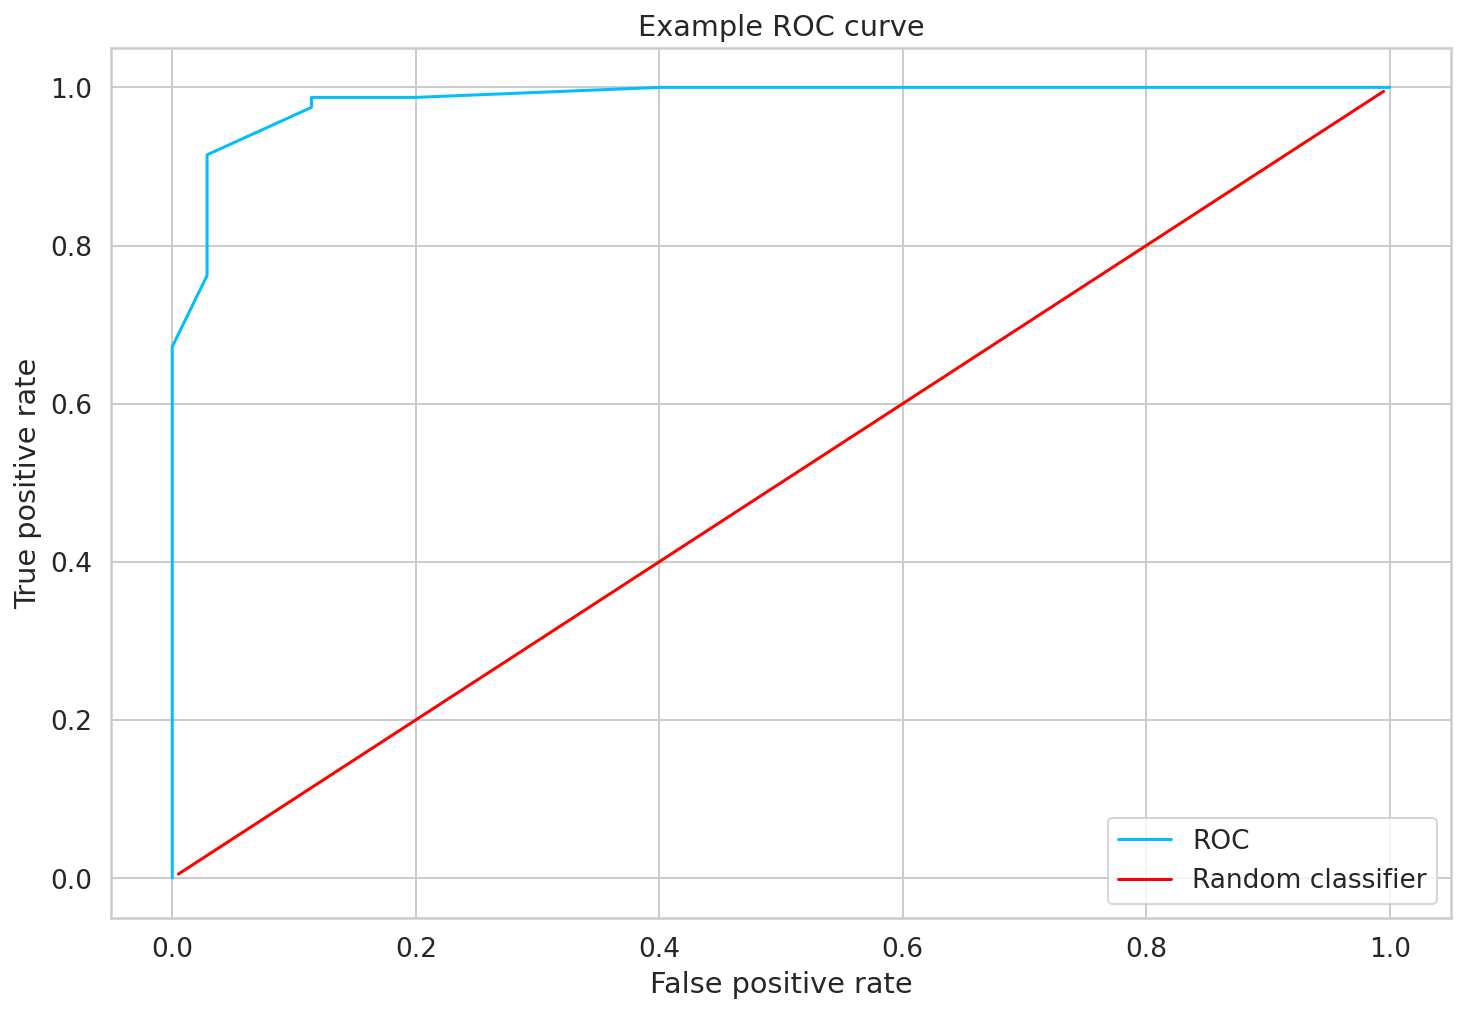

In [ ]:
from sklearn import metrics
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

# Training

In [ ]:
import os
checkpoint_callback = ModelCheckpoint( # validation loss를 기반으로 최적 모델 저장 및 선정
  dirpath="/content/gdrive/MyDrive/Project/Capstone/best_checkpoint",
  filename="{epoch}-{train_loss:.2f}-{val_loss:.2f}",
  # every_n_epochs=1,
  save_top_k = -1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
# logger = TensorBoardLogger("lightning_logs", name="toxic-comments") # tensorboard에 진행상황 기록

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2) # 2epoch동안 loss가 개선되지 않으면 earlystopping

In [ ]:
import tensorflow as tf
checkpoint_path = os.path.dirname('/content/gdrive/MyDrive/Project/Capstone/best_checkpoint/epoch=2-train_loss=0.30-train_acc=0.00-val_loss=0.31-val_acc=0.00.hj.ckpt')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
## 모델 학습 시작 !!!
trainer = pl.Trainer(
  #logger=logger,
  # checkpoint_callback=cp_callback,
  max_epochs=N_EPOCHS,
  progress_bar_refresh_rate=30,
  gpus=1,
  callbacks=[checkpoint_callback, early_stopping_callback]
  # accelerator= "tpu",
  # devices=8
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.fit(model, data_module) # 2epoch동안만 개선됨.

Missing logger folder: /content/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/gdrive/MyDrive/Project/Capstone/best_checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 40.0 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.401 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
Epoch 0, global step 40: 'val_loss' reached 0.44629 (best 0.44629), saving model to '/content/gdrive/MyDrive/Project/Capstone/best_checkpoint/epoch=0-train_loss=0.45-val_loss=0.45.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 80: 'val_loss' reached 0.31590 (best 0.31590), saving model to '/content/gdrive/MyDrive/Project/Capstone/best_checkpoint/epoch=1-train_loss=0.34-val_loss=0.32.ckpt' as top 2


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 120: 'val_loss' reached 0.28163 (best 0.28163), saving model to '/content/gdrive/MyDrive/Project/Capstone/best_checkpoint/epoch=2-train_loss=0.30-val_loss=0.28.ckpt' as top 3


In [ ]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."


MisconfigurationException: ignored

# Predictions

In [ ]:
# validation loss에 따른 모델의 best version 확인

trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

In [ ]:
THRESHOLD = 0.5
test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

# Evaluation

In [ ]:
# Let’s get a more complete overview of the performance of our model. We’ll start by taking all predictions and labels from the validation set:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ToxicCommentsDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
accuracy(predictions, labels, threshold=0.5) # 정확도

tensor(0.9596)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}") # 결과 매우 좋음

AUROC per tag
H01B: 0.0
H01C: 0.0
H01F: 0.0
H01G: 0.0
H01H: 0.0
H01J: 0.0
H01K: 0.0
H01L: 0.75
H01M: 0.0
H01P: 0.0
H01Q: 0.5555555820465088
H01R: 0.5625
H01S: 0.0
H01T: 0.0
H02B: 0.0
H02G: 0.0
H02H: 0.0
H02J: 0.0
H02K: 0.2222222089767456
H02M: 0.0
H02N: 0.0
H02P: 0.0
H02S: 0.0
H03B: 0.0
H03C: 0.0
H03D: 0.0
H03F: 0.0
H03G: 0.0
H03H: 0.0
H03J: 0.0
H03K: 0.0
H03L: 0.0
H03M: 0.0
H04B: 0.6666666865348816
H04H: 0.0
H04J: 0.0
H04K: 0.0
H04L: 0.0
H04M: 0.0
H04N: 0.2222222089767456
H04Q: 0.0
H04R: 0.0
H04S: 0.0
H04T: 0.0
H04W: 0.6666666865348816
H05B: 0.7777777910232544
H05C: 0.0
H05F: 0.0
H05G: 0.0
H05H: 0.0
H05K: 0.6875
H99Z: 0.0


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [ ]:
y_pred = predictions.numpy() # 결과 꽤 좋음 -> 에포크 별로 돌리지도 않았는데 신기하다..
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > 0.5, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))


              precision    recall  f1-score   support

        H01B       0.00      0.00      0.00         0
        H01C       0.00      0.00      0.00         0
        H01F       0.00      0.00      0.00         0
        H01G       0.00      0.00      0.00         0
        H01H       0.00      0.00      0.00         0
        H01J       0.00      0.00      0.00         0
        H01K       0.00      0.00      0.00         0
        H01L       0.00      0.00      0.00         4
        H01M       0.00      0.00      0.00         0
        H01P       0.00      0.00      0.00         0
        H01Q       0.00      0.00      0.00         1
        H01R       0.20      1.00      0.33         2
        H01S       0.00      0.00      0.00         0
        H01T       0.00      0.00      0.00         0
        H02B       0.00      0.00      0.00         0
        H02G       0.00      0.00      0.00         0
        H02H       0.00      0.00      0.00         0
        H02J       0.00    